# PID Controller Testing

This notebook tests the PID controller implementation used in the boat simulator.


In [1]:
# Install dependencies
%pip install matplotlib


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
from boat_simulator.nodes.low_level_control.control import RobotPID


class RobotArm:
    def __init__(self, pid, mass, start_position, target_position, dt):
        self.pid = pid
        self.mass = mass
        self.start_position = start_position
        self.target_position = target_position
        self.dt = dt

        self.times = list()
        self.positions = list()

    def run(self, num_steps, start_upward_force):
        # Fill in values for time 0
        self.times.append(0)
        self.positions.append(self.start_position)

        # Define starting kinematics
        prev_acceleration = 0
        prev_velocity = 0
        prev_position = self.start_position

        force = start_upward_force

        for i in range(num_steps):
            current_time = (i + 1) * self.dt

            # Step 1: Get the feedback from PID and store the new force (but do not update yet)
            feedback = self.pid.step(prev_position, self.target_position)

            # Step 2: Compute the new kinematics with previous info, but do not update yet
            acceleration = self.__compute_acceleration(force)
            velocity = self.__compute_velocity(prev_velocity, prev_acceleration)
            position = self.__compute_position(prev_position, prev_velocity, prev_acceleration)

            # Step 3: Add all new data to arrays

            self.times.append(current_time)
            self.positions.append(position)

            # Step 4: Update the force

            force += feedback

            # Step 5: Update the previous kinematic values to be the newly computed ones

            prev_position = position
            prev_velocity = velocity
            prev_acceleration = acceleration

        return self.times, self.positions

    def __compute_acceleration(self, prev_upward_force):
        downward_force = 9.81 * self.mass

        return (downward_force - prev_upward_force) / self.mass

    def __compute_velocity(self, prev_velocity, prev_acceleration):
        return prev_velocity + (prev_acceleration * self.dt)

    def __compute_position(self, prev_position, prev_velocity, prev_acceleration):
        accel_comp = (prev_acceleration * (self.dt**2)) / 2
        return prev_position + (prev_velocity * self.dt) + accel_comp


In [12]:
"""Robot Arm Test implementation for PID Controller"""

from abc import ABC, abstractmethod
from typing import Any, List


from boat_simulator.common.types import Scalar
from boat_simulator.common.utils import bound_to_180
from boat_simulator.nodes.low_level_control.control import RobotPID

GRAVITY = 9.8


class RobotArm:
    # Private class member defaults
    __mass: float = 0.0
    __target_position: Scalar = 0.0
    __current_position: Scalar = 0.0
    __time_period: Scalar = 0.0
    __position_log: List[Scalar] = list()
    __time_log: List[Scalar] = list()

    def __init__(
        self,
        mass: float,
        target_position: Scalar,
        current_position: Scalar,
        time_period: Scalar,
        position_log: list,
        time_log: list,
    ):
        self.__mass = mass
        self.__target_position = target_position
        self.__current_position = current_position
        self.__time_period = time_period
        self.__position_log = position_log
        self.__time_log = time_log

    def run(
        self,
        count: int,
        controller: RobotPID,
        force: float,
        velocity: float,
    ) -> Scalar:
        weight = self.__mass * GRAVITY
        running_time = 0
        prev_position = self.__current_position
        prev_velocity = 0
        prev_acceleration = 0
        for _ in range(count):
            feedback = controller.step(prev_position, self.target_position)

            acceleration = (weight - force) / self.__mass

            velocity = prev_velocity + (prev_acceleration * self.__time_period)

            accel_comp = (prev_acceleration * (self.__time_period**2)) / 2

            position = prev_position + (prev_velocity * self.__time_period) + accel_comp

            self.__position_log.append(position)
            self.__time_log.append(running_time)

            running_time += self.__time_period
            force += feedback

            self.__current_position = position
            prev_position = position
            prev_velocity = velocity
            prev_acceleration = acceleration


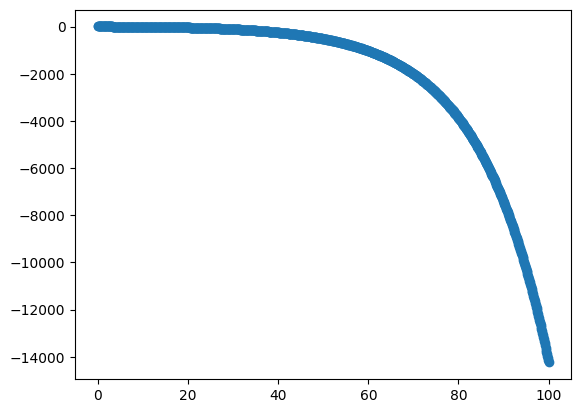

In [12]:
from matplotlib import pyplot as plt

pid = RobotPID(
    kp=0.00002690, ki=0.0001, kd=0.00001, time_period=0.1, buf_size=50, sum_threshold=10
)
robot = RobotArm(
    pid=pid,
    mass=1,
    start_position=1,
    target_position=0,
    dt=0.1,
)

breakpoint()

x, y = robot.run(1000, 10)

plt.scatter(x, y)

# function to show the plot
plt.show()
